# How many items will be collected based on the number of participants?

We first load the data.

In [1]:
import pandas as pd
import sqlite3

old = pd.read_csv('../data/cleanups.csv')[['TotalVolunteers', 'Totalltems_EventRecord', 'NAME']].rename(columns={'TotalVolunteers': 'Participants', 'Totalltems_EventRecord': 'Items', 'NAME': 'State'})
new = pd.read_csv('../data/new-cleanups.csv')[['People', 'Total Items Collected', 'State']].rename(columns={'People': 'Participants', 'Total Items Collected': 'Items'})
new['State'] = new['State'].str.split(',').str[0]
cleanups = pd.concat([new, old]).reset_index().drop(columns=['index']).dropna().reset_index()
cleanups['Participants'] = cleanups['Participants'].astype(int)
cleanups['Items'] = cleanups['Items'].astype(int)
cleanups

/Users/abhinavmadahar/Documents/ocean_plastic_pollution/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5,21,22,23,24,34,36,37) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/abhinavmadahar/Documents/ocean_plastic_pollution/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,index,Participants,Items,State
0,0,1,5990,California
1,1,1,57,Wisconsin
2,2,2,126,Queensland
3,3,2,20,Queensland
4,4,1,70,La Digue
...,...,...,...,...
92600,102751,1,35,California
92601,102752,1,38,California
92602,102753,12,1227,California
92603,102754,28,212,California


Now, let's plot the number of items collected by the number of participants.

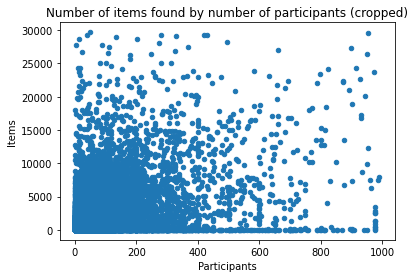

In [2]:
cleanups[(cleanups['Participants'] < 1000) & (cleanups['Items'] < 30000)].plot(x='Participants', y='Items', kind='scatter', title='Number of items found by number of participants (cropped)');

As you can see, there is no clear pattern in this plot.
Let's restrict ourselves to a few regions and few the same plot above when focusing just on that region.

Number of items found by number of participants in the 6 states (or equivalent) with the most cleanups (cropped)


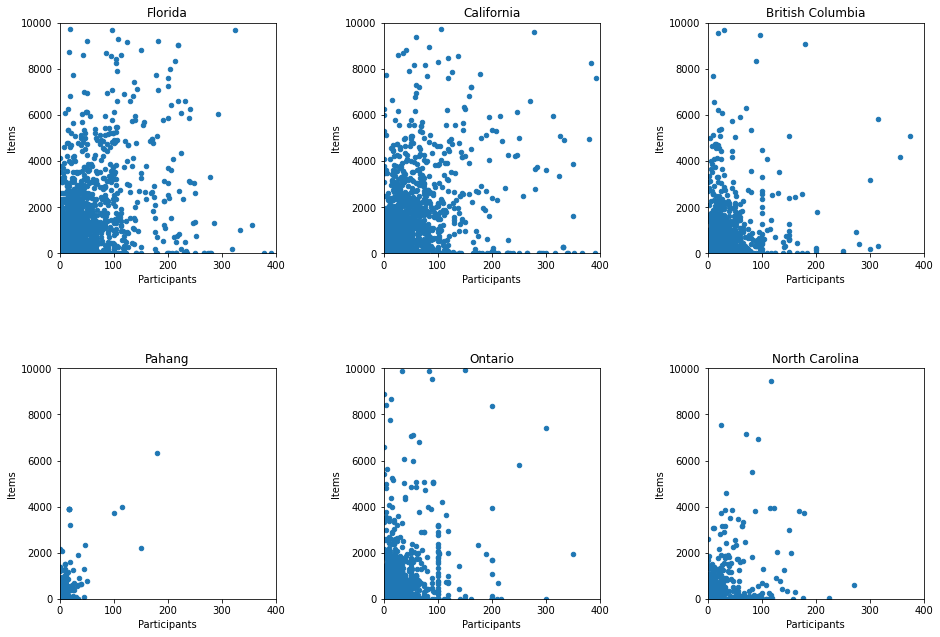

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3)
axes = axes.ravel()

print('Number of items found by number of participants in the 6 states (or equivalent) with the most cleanups (cropped)')
fig.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0.5, hspace=0.5)

for state, axis in zip(cleanups['State'].value_counts()[:6].keys(), axes):
    cleanups[(cleanups['State'] == state) & (cleanups['Participants'] < 400) & (cleanups['Items'] < 10000)].plot(x='Participants', y='Items', kind='scatter', title=state, ax=axis, xlim=(0, 400), ylim=(0, 10000));

As you can see, there still is no clear pattern.
For now, we cannot reasonably predict the number of items found by the number of partipants.
Let's see if we can predict a range for it.
Let's say that we're given the number of participants, and we want to find the smallest interval where there is a ~95\% chance that the number of items found will be in it.
First, let's find the 95<sup>th</sup> percentile for each number of participants.

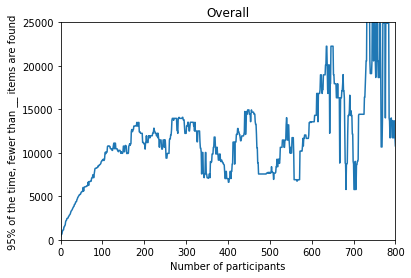

Restricted to the 10 major states


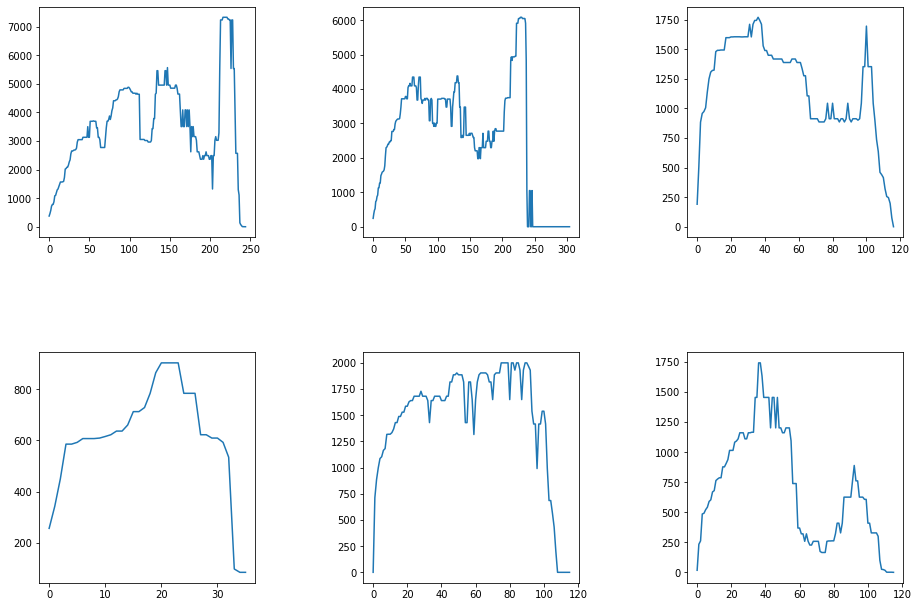

In [4]:
from scipy.signal import medfilt

plt.title('Overall')
data = cleanups.groupby('Participants').quantile(0.95)
plt.xlabel('Number of participants')
plt.ylabel('95% of the time, fewer than __ items are found')
plt.xlim(0, 800)
plt.ylim(0, 25000)
plt.plot(medfilt(data['Items'], 31))
plt.show()

fig, axes = plt.subplots(2, 3)
axes = axes.ravel()

print('Restricted to the 10 major states')
fig.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0.5, hspace=0.5)

for state, axis in zip(cleanups['State'].value_counts()[:10].keys(), axes):
    cleanups_of_state = cleanups[(cleanups['State'] == state)]
    data = cleanups_of_state.groupby('Participants').quantile(0.95)
    axis.plot(medfilt(data['Items'], 31))

As you can see, there a slight pattern here.

Let's see the accuracy on the overall model.

In [5]:
n_correct = 0
data = cleanups.groupby('Participants').quantile(0.95)
filtered = medfilt(data['Items'], 31)
for i, (participants, items) in enumerate(zip(cleanups['Participants'], cleanups['Items'])):
    try:
        bound = filtered[participants]
    except IndexError:
        bound = max(filtered)
    if items < bound:
        n_correct += 1
n_correct / len(cleanups)

0.9576048809459532

As you can see, the model is 95\% accurate, which makes sense.
We can change the quartile to change the accuracy.
This is certainly not a perfect way to do it, but it's something.